**Importing stuff:**

In [1]:


# Data manipulation
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt

# Open Data from Kaggel
%pip install -q opendatasets
import opendatasets as od
import os

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable

# PyToch TorchVision
import torchvision
import torchvision.transforms as transforms

# Utils
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import opendatasets as od
import os

# TensorFlow
import tensorflow as tf

# Keras
from tensorflow.keras import datasets, layers, models

In [2]:
# insert ypu kaggle  username and key
od.download('https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small',data_dir="dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: natalierotermund
Your Kaggle Key: ··········


100%|██████████| 565M/565M [00:07<00:00, 82.5MB/s]


In [3]:
df = pd.read_csv('dataset/fashion-product-images-small/styles.csv', on_bad_lines='skip')
df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:

SMALL_DATASET = True

df_data = pd.read_csv("dataset/fashion-product-images-small/styles.csv", on_bad_lines='skip')
image_files = os.listdir("dataset/fashion-product-images-small/images")


## **Data preparation**

**Cleaning of dataset:**

In [5]:
df_data.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [6]:
df_data.dropna(inplace=True)

#check if file exists
df_data['file_found'] = df_data['id'].apply(lambda x: f"{x}.jpg" in image_files)

df_data['file_found'].value_counts()

mask = df_data['file_found']
df_data = df_data[mask].reset_index(drop=True)



In [7]:
df_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,True


**Deciding the labels for the Dataset:**

In [8]:
#see what is goning on with the labels

cat_columns = ['gender', 'masterCategory', 'subCategory', 'articleType','baseColour', 'season', 'year', 'usage']

for col in cat_columns:
    print(col)
    print(df_data[col].unique())
    print('-------------------------')

gender
['Men' 'Women' 'Boys' 'Girls' 'Unisex']
-------------------------
masterCategory
['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
-------------------------
subCategory
['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Scarves' 'Dress' 'Loungewear and Nightwear'
 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers' 'Skin Care' 'Makeup'
 'Free Gifts' 'Ties' 'Accessories' 'Nails' 'Beauty Accessories'
 'Water Bottle' 'Skin' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
-------------------------
articleType
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lips

In [9]:
#removing all labels below 500 items

value_counts = df_data['articleType'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <500:
        break

types_used = indexes[:i]
print('Article types used: ',types_used)

Article types used:  Index(['Tshirts', 'Shirts', 'Casual Shoes', 'Watches', 'Sports Shoes',
       'Kurtas', 'Tops', 'Handbags', 'Heels', 'Sunglasses', 'Wallets',
       'Flip Flops', 'Sandals', 'Briefs', 'Belts', 'Backpacks', 'Socks',
       'Formal Shoes', 'Perfume and Body Mist', 'Jeans', 'Shorts', 'Trousers',
       'Flats'],
      dtype='object')


In [10]:
value_counts = df_data['baseColour'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

colours_used = indexes[:i]
print('Base Colours used: ',colours_used)

Base Colours used:  Index(['Black', 'White', 'Blue', 'Brown', 'Grey', 'Red', 'Green', 'Pink',
       'Navy Blue', 'Purple', 'Silver'],
      dtype='object')


In [11]:
value_counts = df_data['subCategory'].value_counts()

indexes = value_counts.index

values = value_counts.values

for i in range(len(value_counts)):

    if values[i] <1000:
        break

subCategory_used = indexes[:i]
print('sub Category used: ',subCategory_used)

sub Category used:  Index(['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches', 'Innerwear',
       'Jewellery', 'Eyewear', 'Fragrance'],
      dtype='object')


In [12]:
df_data = df_data[df_data['articleType'].isin(types_used)]
df_data = df_data[df_data['baseColour'].isin(colours_used)]
df_data = df_data[df_data['subCategory'].isin(subCategory_used)]

In [13]:
#Drop unnecessary colums
df_data.drop(['gender', 'masterCategory','season', 'year', 'usage', 'productDisplayName'], axis=1, inplace=True)

In [13]:
df_data.head()

,id,subCategory,articleType,baseColour,file_found
0,15970,Topwear,Shirts,Navy Blue,True
1,39386,Bottomwear,Jeans,Blue,True
2,59263,Watches,Watches,Silver,True
4,53759,Topwear,Tshirts,Grey,True
5,1855,Topwear,Tshirts,Grey,True


In [14]:
df_data.describe()

,id
count,26136.000000
mean,25871.864210
std,16272.013115
min,1163.000000
25%,11397.500000
50%,24097.500000
75%,39168.250000
max,60000.000000


**Append images:**

In [15]:
# insert ypu kaggle  username and key
df_data['filename'] = df_data['id'].apply(lambda x: os.path.join("dataset/fashion-product-images-small/images/",str(x)+".jpg"))

df_data.head()

,id,subCategory,articleType,baseColour,file_found,filename
0,15970,Topwear,Shirts,Navy Blue,True,dataset/fashion-product-images-small/images/15...
1,39386,Bottomwear,Jeans,Blue,True,dataset/fashion-product-images-small/images/39...
2,59263,Watches,Watches,Silver,True,dataset/fashion-product-images-small/images/59...
4,53759,Topwear,Tshirts,Grey,True,dataset/fashion-product-images-small/images/53...
5,1855,Topwear,Tshirts,Grey,True,dataset/fashion-product-images-small/images/18...


In [16]:
#dropping all lines file not found

mask = df_data['file_found']
df_data = df_data[mask].reset_index(drop=True)

#Drop file_found colum
df_data.drop(['file_found'], axis=1, inplace=True)


In [17]:
df_data.head()

,id,subCategory,articleType,baseColour,filename
0,15970,Topwear,Shirts,Navy Blue,dataset/fashion-product-images-small/images/15...
1,39386,Bottomwear,Jeans,Blue,dataset/fashion-product-images-small/images/39...
2,59263,Watches,Watches,Silver,dataset/fashion-product-images-small/images/59...
3,53759,Topwear,Tshirts,Grey,dataset/fashion-product-images-small/images/53...
4,1855,Topwear,Tshirts,Grey,dataset/fashion-product-images-small/images/18...


In [17]:
df_data['filename']

0        dataset/fashion-product-images-small/images/15...
1        dataset/fashion-product-images-small/images/39...
2        dataset/fashion-product-images-small/images/59...
3        dataset/fashion-product-images-small/images/53...
4        dataset/fashion-product-images-small/images/18...
                               ...                        
26131    dataset/fashion-product-images-small/images/42...
26132    dataset/fashion-product-images-small/images/17...
26133    dataset/fashion-product-images-small/images/18...
26134    dataset/fashion-product-images-small/images/46...
26135    dataset/fashion-product-images-small/images/51...
Name: filename, Length: 26136, dtype: object

In [52]:
df_data = df_data.sample(n=10000, random_state=0)

In [53]:
df_data.head()

,id,subCategory,articleType,baseColour,filename
1834,9462,Topwear,Shirts,White,dataset/fashion-product-images-small/images/94...
9445,36655,Bags,Handbags,Black,dataset/fashion-product-images-small/images/36...
15808,32930,Topwear,Shirts,Black,dataset/fashion-product-images-small/images/32...
7539,12607,Topwear,Tops,Purple,dataset/fashion-product-images-small/images/12...
18649,41745,Topwear,Tshirts,White,dataset/fashion-product-images-small/images/41...


In [54]:
df_data['filename']

1834     dataset/fashion-product-images-small/images/94...
9445     dataset/fashion-product-images-small/images/36...
15808    dataset/fashion-product-images-small/images/32...
7539     dataset/fashion-product-images-small/images/12...
18649    dataset/fashion-product-images-small/images/41...
                               ...                        
16451    dataset/fashion-product-images-small/images/40...
8656     dataset/fashion-product-images-small/images/12...
4755     dataset/fashion-product-images-small/images/20...
25706    dataset/fashion-product-images-small/images/35...
11646    dataset/fashion-product-images-small/images/11...
Name: filename, Length: 10000, dtype: object

### **Building the model**

In [55]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_path = df_data['filename'][1834]
image = load_img(image_path)
image = img_to_array(image)
image.shape

(80, 60, 3)

In [23]:
#normalize images by fixing width and height
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60

In [24]:
def process_image(image_path):
    image = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT,3))
    image = img_to_array(image)
    return image

In [25]:
def append_images(column):
    images = []
    for file_path in column:
        images.append(process_image(file_path))
    return np.array(images)

**Splitting and definition of output categories:**

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [29]:
output_labels = ["subCategory","articleType","baseColour"]

In [30]:
(X_filepath_train, X_filepath_test,
 y_train,y_test) = train_test_split(df_data["filename"],df_data[output_labels],
                                                    test_size=0.2, random_state=42)

In [31]:
X_train = append_images(X_filepath_train)
X_test = append_images(X_filepath_test)

In [32]:
y_train.head()

,subCategory,articleType,baseColour
24450,Shoes,Heels,Brown
2546,Shoes,Heels,Black
11474,Bags,Handbags,Brown
21311,Topwear,Kurtas,Brown
10643,Shoes,Heels,Black


In [29]:
y_test.head()

,subCategory,articleType,baseColour
16130,Shoes,Casual Shoes,Purple
7406,Topwear,Shirts,Grey
3840,Bags,Backpacks,Pink
18120,Shoes,Formal Shoes,Brown
12710,Topwear,Tshirts,Green


In [26]:
label_encoders = {}
data_train = {}
data_test = {}

In [33]:
for label in output_labels:
    label_encoder = LabelBinarizer()
    encoded_data_train = label_encoder.fit_transform(y_train[label].to_numpy())
    encoded_data_test = label_encoder.transform(y_test[label].to_numpy())

    label_encoders[label] = label_encoder
    data_train[label] = encoded_data_train
    data_test[label] = encoded_data_test

**The model:**

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense,BatchNormalization, MaxPooling2D, Conv2D, Activation, Input, Flatten,Dropout)

In [37]:
img_inputs = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(img_inputs)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)

In [38]:
def make_branch(res_input, n_out, name):
    x = Dense(256, activation='relu')(res_input)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(n_out)(x)
    x = Activation("softmax",name=name)(x)
    return x

In [34]:
branches = {}

In [39]:
for label in output_labels:
    branches[label] = make_branch(x, len(label_encoders[label].classes_),label)

In [40]:
model = Model(inputs=img_inputs,outputs=branches)

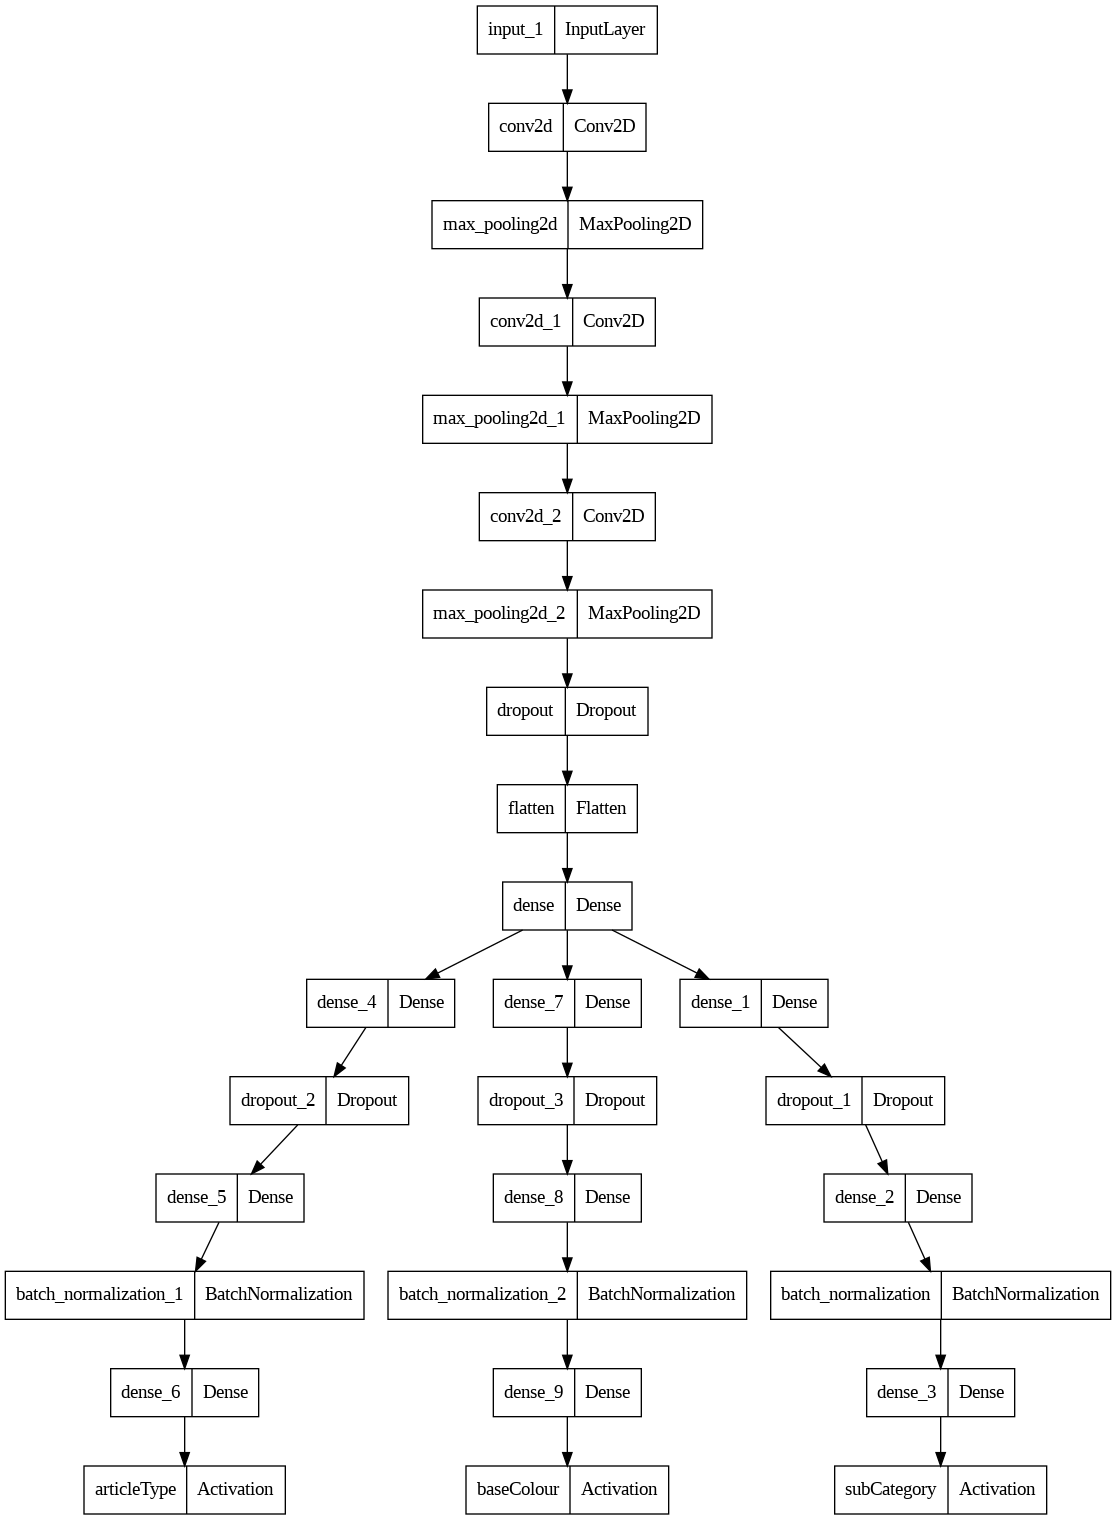

In [38]:
keras.utils.plot_model(model)

In [41]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")

In [38]:
EPOCHS=40
history = model.fit(
    X_train,
    data_train,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/40
250/250 [==============================] - 83s 316ms/step - loss: 4.3240 - articleType_loss: 1.7144 - baseColour_loss: 1.9599 - subCategory_loss: 0.6497 - articleType_accuracy: 0.4597 - baseColour_accuracy: 0.3801 - subCategory_accuracy: 0.7929
Epoch 2/40
250/250 [==============================] - 79s 318ms/step - loss: 2.4753 - articleType_loss: 0.8348 - baseColour_loss: 1.4517 - subCategory_loss: 0.1888 - articleType_accuracy: 0.6899 - baseColour_accuracy: 0.5345 - subCategory_accuracy: 0.9456
Epoch 3/40
250/250 [==============================] - 78s 312ms/step - loss: 2.0999 - articleType_loss: 0.6450 - baseColour_loss: 1.3282 - subCategory_loss: 0.1267 - articleType_accuracy: 0.7563 - baseColour_accuracy: 0.5623 - subCategory_accuracy: 0.9639
Epoch 4/40
250/250 [==============================] - 78s 312ms/step - loss: 1.8651 - articleType_loss: 0.5305 - baseColour_loss: 1.2294 - subCategory_loss: 0.1052 - articleType_accuracy: 0.8009 - baseColour_accuracy: 0.5989 - subCa

<Axes: >

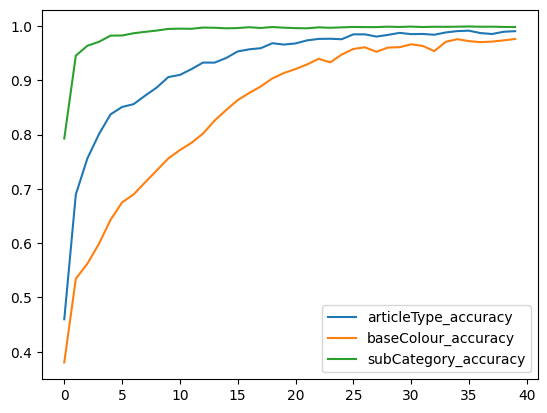

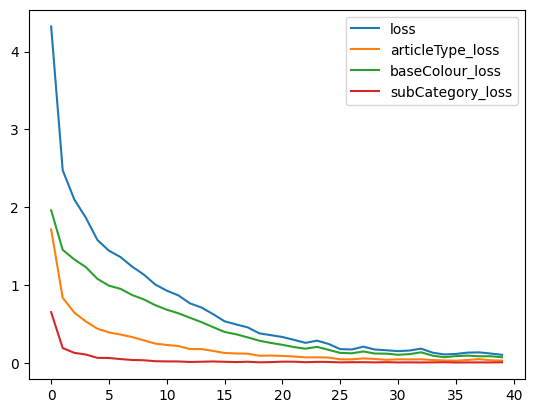

In [39]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,[col for col in history_df.columns if 'accuracy' in col and 'val' not in col]].plot()
history_df.loc[:,[col for col in history_df.columns if 'loss' in col and 'val' not in col]].plot()

In [40]:
model.save('group1_02.keras')

In [41]:
outputs = model.predict(X_test)

63/63 [==============================] - 6s 96ms/step


In [42]:
predictions = {}
accuracies = {}

In [43]:
for label in output_labels:
    predictions[label] = label_encoders[label].classes_[outputs[label].argmax(axis=1)]

In [44]:
from sklearn.metrics import accuracy_score

In [45]:
for label in output_labels:
    accuracies[label] = accuracy_score(y_test[label],predictions[label])

In [46]:
for label in output_labels:
    print(
        "This model has accuracy of {:.2f}% for the label {}.".format(accuracies[label]*100,label)
    )

This model has accuracy of 98.20% for the label subCategory.
This model has accuracy of 86.75% for the label articleType.
This model has accuracy of 68.50% for the label baseColour.


In [42]:
# Get the absolute path of the saved model file
model_path = os.path.abspath('/content/group1_02.keras')

print(f"The saved model is located at: {model_path}")

The saved model is located at: /content/group1_02.keras


1/1 [==============================] - 2s 2s/step


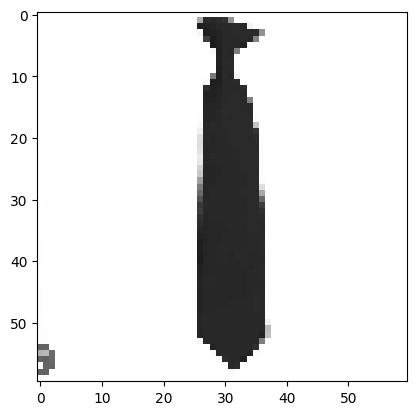

This items subCategory is most likely Fragrance. With a 80.38 percent confidence.
This items articleType is most likely Kurtas. With a 90.02 percent confidence.
This items baseColour is most likely Black. With a 90.29 percent confidence.


In [43]:
# Load the model
model = tf.keras.models.load_model('/content/group1_01.keras')

image_path_test1 = '/content/tie1_720.jpg'
input_image_test1 = np.expand_dims(process_image(image_path_test1), axis=0)

output_ex = model.predict(input_image_test1)

for label in output_labels:
    output_ex[label] = output_ex[label][0]

image = load_img(image_path_test1, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(image, interpolation='nearest')
plt.show()
for label in output_labels:
    print(
        "This items {} is most likely {}. With a {:.2f} percent confidence."
        .format(label,label_encoders[label].classes_[output_ex[label].argmax()], 100 * output_ex[label].max())
    )


In [65]:
#second color prpability

# Get the index of the highest confidence prediction
highest_index = output_ex[label].argmax()

# Get the second highest confidence prediction (excluding the highest one)
second_highest_index = output_ex[label].argsort()[-2]

# Retrieve the class names corresponding to the indices
highest_label = label_encoders[label].classes_[highest_index]
second_highest_label = label_encoders[label].classes_[second_highest_index]

# Calculate the confidence percentages
highest_confidence = 100 * output_ex[label][highest_index]
second_highest_confidence = 100 * output_ex[label][second_highest_index]

# Display the results
print("This item {} is most likely {}. With a {:.2f}% confidence."
      " The second most likely label is {} with a {:.2f}% confidence."
      .format(label, highest_label, highest_confidence, second_highest_label, second_highest_confidence))

This item baseColour is most likely Blue. With a 86.51% confidence. The second most likely label is White with a 13.27% confidence.


## **Show similar images**

In [44]:
output = model.predict(input_image_test1)

for label in output_labels:
    output[label] = output[label][0]

output[label]


1/1 [==============================] - 0s 20ms/step


array([9.0293819e-01, 6.3079465e-03, 8.2109980e-03, 2.7453281e-02,
       1.8665425e-03, 5.7906564e-03, 1.3524918e-03, 3.4038657e-03,
       6.3772168e-04, 2.8617058e-03, 3.9176751e-02], dtype=float32)

In [45]:
predictions = {}
for label in output_labels:
    predictions[label] = label_encoders[label].classes_[output[label].argmax(axis=0)]

predictions

{'subCategory': 'Fragrance', 'articleType': 'Kurtas', 'baseColour': 'Black'}

In [46]:
query_mask = ""
for label in output_labels:
    query_mask += str(label + " == '" + predictions[label] + "' & ")
query_mask = query_mask[:-3]

In [47]:
query_mask

"subCategory == 'Fragrance' & articleType == 'Kurtas' & baseColour == 'Black'"

In [49]:
suggested_images = df_data.query(query_mask)

suggested_images["filename"]

Series([], Name: filename, dtype: object)

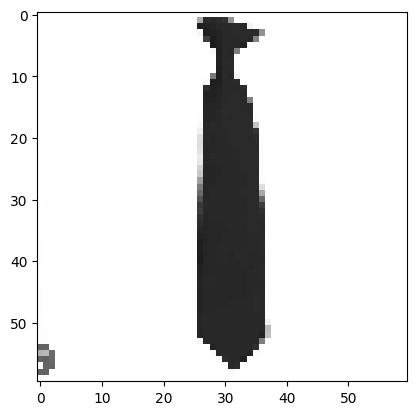

In [50]:
image = load_img(image_path_test1, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
plt.imshow(image, interpolation='nearest')
plt.show()


In [51]:
for index, row in suggested_images.iterrows():
    image = load_img(row["filename"], target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.imshow(image, interpolation='nearest')
    plt.show()